In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(1, '../')

import experiment
import pickle
from utils import *
from Architectures import *
import random, os
suppress_warnings()
EPOCHS = 256


def countp(model, params):
    tmp = model(**params)
    tmp.build(input_shape=(1,15,7))
    return tmp.count_params()


n_params = []

os.environ['PYTHONHASHSEED']=str(0)
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

def human_format(num):
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    # add more suffixes if you need them
    return '%.0f%s' % (num, ['', 'K', 'M', 'G', 'T', 'P'][magnitude])


filename = '../data/data100k_raw_combined_atlas_cut.pkl'
n_experiments = 8
SUFFIX = 'latent28'


#TESTING ######
# EPOCHS = 2
# filename = '../data/data50k_raw_combined_atlas_cut_small.pkl'
# n_experiments = 2
# SUFFIX = 'latent28'
###########

ERROR in cling::CIFactory::createCI(): cannot extract standard library include paths!
Invoking:
  LC_ALL=C x86_64-conda-linux-gnu-c++  -O3 -DNDEBUG -xc++ -E -v /dev/null 2>&1 | sed -n -e '/^.include/,${' -e '/^ \/.*++/p' -e '}'
Results was:
With exit code 0


Welcome to JupyROOT 6.22/08


2022-07-19 15:29:04.252159: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-19 15:29:04.252281: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
import seaborn as sns
import os

#to get latex to work 
os.environ['PATH'] = "%s:/usr/local/cuda-11.2/bin:/usr/local/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/opt/anaconda/bin:/home/delon/texlive/bin/x86_64-linux:/home/delon/.local/bin:/home/delon/bin"%os.environ['PATH']


PIl64 = experiment.Experimenter(filename)
PIl64.fromSaved()

PI = experiment.Experimenter(filename)
PI.fromSaved(suffix=SUFFIX)

Initializing Experimenter
	Loading Data from ../data/data100k_raw_combined_atlas_cut.pkl
	Data Loaded
	Creating Splits
	Splits Created
Done initalizing
Loading Experimenter from Saved Experimenter at /data/delon/experimenter/data100k_raw_combined_atlas_cut
Experimenter Loaded
Getting split
Split Stored
Loading models
{'nested_concat_70_4_64_3': 'models/data100k_raw_combined_atlas_cut_nested_concat_70_4_64_3', 'nested_concat_general_68_3_64_3': 'models/data100k_raw_combined_atlas_cut_nested_concat_general_68_3_64_3', 'particlewise_128_4_64': 'models/data100k_raw_combined_atlas_cut_particlewise_128_4_64', 'tripletwise_5_(64, 128, 256, 128, 64)_64': 'models/data100k_raw_combined_atlas_cut_tripletwise_5_(64, 128, 256, 128, 64)_64', 'pairwise_5_(64, 128, 256, 128, 64)_64': 'models/data100k_raw_combined_atlas_cut_pairwise_5_(64, 128, 256, 128, 64)_64', 'pairwise_nl_5_(64, 128, 256, 128, 64)_32_64': 'models/data100k_raw_combined_atlas_cut_pairwise_nl_5_(64, 128, 256, 128, 64)_32_64', 'pairwis

2022-07-19 15:29:39.822145: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-19 15:29:39.822197: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-19 15:29:39.822246: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (top1.hep.utexas.edu): /proc/driver/nvidia/version does not exist
2022-07-19 15:29:39.823284: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
latent64 = PIl64.models['%s_%s'%('pairwise', PIl64.get_tail_string(model_params_dict['pairwise']))]
latent2 = PI.models['latent_two_5_(64, 128, 256, 128, 2)_64']
latent8 = PI.models['latent_eight_5_(64, 128, 256, 128, 8)_64']

In [5]:
PI.get_ROC('latent_two', model_params_dict['latent_two'])

getting ROC for latent_two
currently on latent_two_5_(64, 128, 256, 128, 2)_64


(array([0.        , 0.        , 0.        , ..., 0.97726361, 0.97733048,
        1.        ]),
 array([0.00000000e+00, 3.32314236e-05, 4.95148212e-03, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00]),
 array([1.99984789e+00, 9.99847889e-01, 9.98715162e-01, ...,
        2.19616995e-05, 2.18937785e-05, 1.10760304e-10], dtype=float32),
 0.9602683074566158)

2022-07-19 15:30:30.160148: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-07-19 15:30:30.163303: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2397305000 Hz


In [6]:
X_test_latent, y_test_latent = PI.get_test_dataset('latent_two')
X_test, y_test = PIl64.get_test_dataset('pairwise')
X_test_ATLAS, y_test_ATLAS = gen_dataset_high_level(PIl64.events_test, PIl64.events_oup_test, PIl64.events_tag_test)

In [7]:
n_cut = int(len(X_test)*0.1)
assert(len(X_test) == len(X_test_latent))

indices = np.random.permutation(len(X_test))
cut = np.s_[indices[:n_cut]]

latent_label = y_test.numpy()[cut]
latent_label_28 = y_test_latent.numpy()[cut]

In [23]:
latent64_embedded = compute_tsne(latent64, X_test=X_test, cut=cut)

64
computing tsne
--------------------------------------------------------------------------------
TSNE(n_jobs=-1, perplexity=1000, random_state=42, verbose=True)
--------------------------------------------------------------------------------
===> Finding 3000 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 5.95 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 16.22 seconds
===> Running optimization with exaggeration=12.00, lr=500.00 for 250 iterations...
Iteration   50, KL divergence 1.2992, 50 iterations in 1.8303 sec
Iteration  100, KL divergence 1.2999, 50 iterations in 1.6437 sec
Iteration  150, KL divergence 1.3002, 50 iterations in 1.6409 sec
Iteration  200, KL divergence 1.3003, 50 iterations in 1.6589 sec
Iteration  250, KL divergence 1.2994, 50 iterations in 1.6654 sec
   --> Time elapsed: 8.44 seconds
===> Running optimization with exaggeration=1.00, lr=500.00 for 500 iterations...
Iteration   50, KL divergen

In [24]:
ATLAS_embedded = compute_tsne_embedded(np.array(X_test_ATLAS)[cut])

8
computing tsne
--------------------------------------------------------------------------------
TSNE(n_jobs=-1, perplexity=1000, random_state=42, verbose=True)
--------------------------------------------------------------------------------
===> Finding 3000 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 5.95 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 16.87 seconds
===> Running optimization with exaggeration=12.00, lr=500.00 for 250 iterations...
Iteration   50, KL divergence 1.3433, 50 iterations in 2.0393 sec
Iteration  100, KL divergence 1.3341, 50 iterations in 2.1438 sec
Iteration  150, KL divergence 1.3342, 50 iterations in 2.1297 sec
Iteration  200, KL divergence 1.3343, 50 iterations in 2.1160 sec
Iteration  250, KL divergence 1.3343, 50 iterations in 2.0059 sec
   --> Time elapsed: 10.44 seconds
===> Running optimization with exaggeration=1.00, lr=500.00 for 500 iterations...
Iteration   50, KL divergen

In [25]:
latent8_embedded = compute_tsne(latent8, cut=cut, X_test=X_test_latent)

8
computing tsne
--------------------------------------------------------------------------------
TSNE(n_jobs=-1, perplexity=1000, random_state=42, verbose=True)
--------------------------------------------------------------------------------
===> Finding 3000 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 5.84 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 15.73 seconds
===> Running optimization with exaggeration=12.00, lr=500.00 for 250 iterations...
Iteration   50, KL divergence 1.4970, 50 iterations in 1.8107 sec
Iteration  100, KL divergence 1.5003, 50 iterations in 1.6957 sec
Iteration  150, KL divergence 1.5004, 50 iterations in 1.5785 sec
Iteration  200, KL divergence 1.5005, 50 iterations in 1.6023 sec
Iteration  250, KL divergence 1.5003, 50 iterations in 1.6398 sec
   --> Time elapsed: 8.33 seconds
===> Running optimization with exaggeration=1.00, lr=500.00 for 500 iterations...
Iteration   50, KL divergenc

In [26]:
latent2_embedded = compute_tsne(latent2, cut=cut, X_test=X_test_latent, perplexity=[1000,1998])

2
computing tsne
--------------------------------------------------------------------------------
TSNE(n_jobs=-1, perplexity=1000, random_state=42, verbose=True)
--------------------------------------------------------------------------------
===> Finding 3000 nearest neighbors using Annoy approximate search using euclidean distance...
Iteration  200, KL divergence 1.4437, 50 iterations in 2.0647 sec
Iteration  250, KL divergence 1.4438, 50 iterations in 1.9700 sec
   --> Time elapsed: 9.89 seconds
===> Running optimization with exaggeration=1.00, lr=500.00 for 500 iterations...
Iteration   50, KL divergence 0.2561, 50 iterations in 1.9703 sec
Iteration  100, KL divergence 0.1882, 50 iterations in 1.8848 sec
Iteration  150, KL divergence 0.1796, 50 iterations in 1.8872 sec
Iteration  200, KL divergence 0.1776, 50 iterations in 1.8644 sec
Iteration  250, KL divergence 0.1772, 50 iterations in 1.8967 sec
Iteration  300, KL divergence 0.1772, 50 iterations in 1.8718 sec
Iteration  350, KL

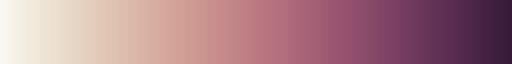

In [27]:
sns.cubehelix_palette(start=2/10, light=.97, as_cmap=True)

[-2.41584530e-16 -5.68434189e-17] [8.80638894 1.51480846]
0.9897723523589574
earth_movers_distance 1.1198405314176716


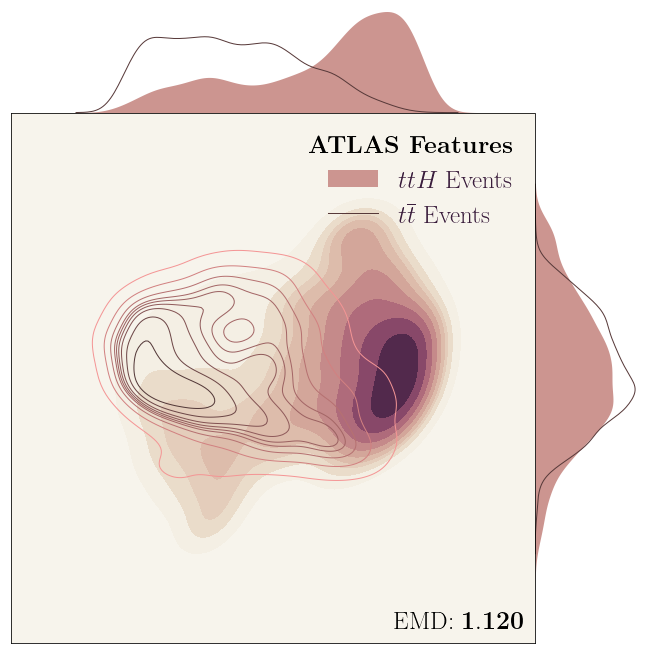

In [28]:
axATLAS = gen_tsne(ATLAS_embedded, latent_label, text=r'\textbf{ATLAS Features}',
                   cmap = sns.cubehelix_palette(start=2/10, light=.97, as_cmap=True), col_aux='#f49595')
axATLAS.savefig('figures/ATLAS_tsne.pdf')

[ 5.21064673e-16 -1.39740071e-16] [7.28857224 3.09615173]
0.9897723523589574
earth_movers_distance 1.5903433542880685


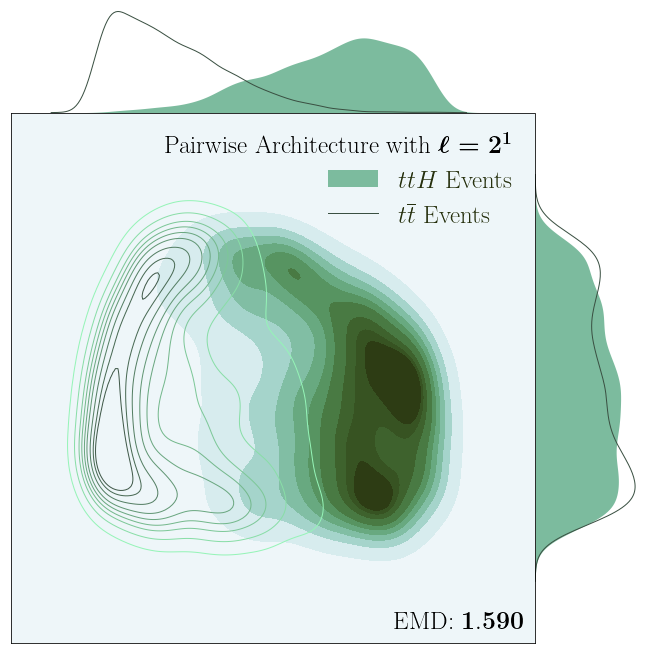

In [29]:
ax = gen_tsne(latent2_embedded, latent_label_28, text=r'{Pairwise Architecture with} \boldmath$\mathbf{\ell=2^1}$',
             cmap=sns.cubehelix_palette(start=14/10, light=.97, as_cmap=True), col_aux='#95f4b7')
ax.savefig('figures/l2_tsne.pdf')

[ 1.89478063e-17 -3.90798505e-17] [4.88797901 2.62170306]
0.9897723523589574
earth_movers_distance 1.3142822638076295


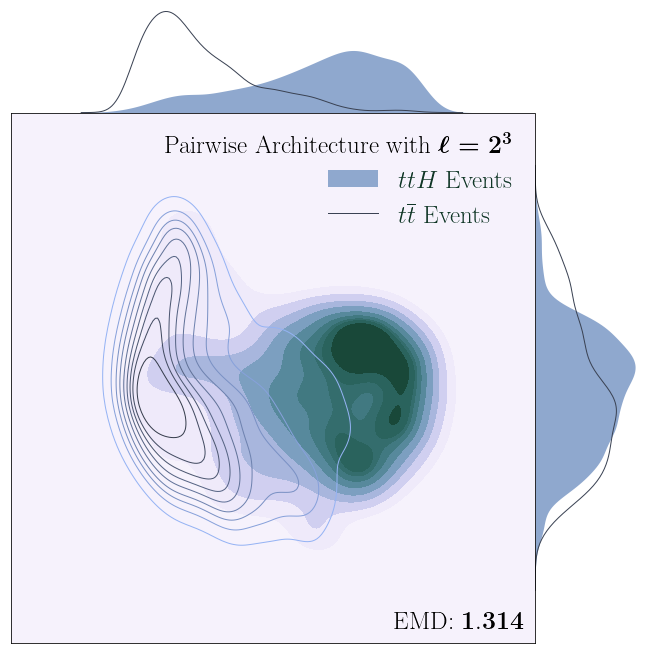

In [30]:
ax = gen_tsne(latent8_embedded, latent_label_28, text=r'{Pairwise Architecture with} \boldmath$\mathbf{\ell=2^3}$',
              cmap=sns.cubehelix_palette(start=20/10, light=.97, as_cmap=True), col_aux='#95b3f4')
ax.savefig('figures/l8_tsne.pdf')

[-7.10542736e-17 -8.82257230e-17] [4.62284574 2.20245655]
0.9897723523589574
earth_movers_distance 1.512970334039453


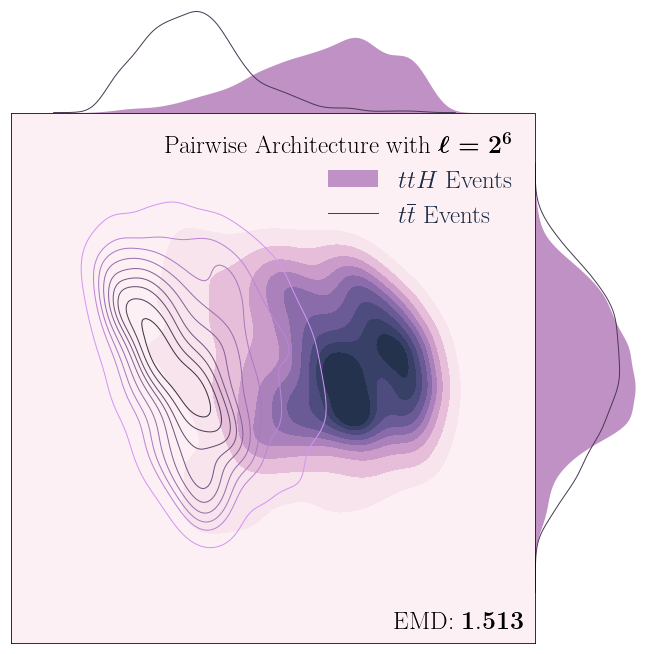

In [31]:
axl64 = gen_tsne(latent64_embedded, latent_label, text=r'{Pairwise Architecture with} \boldmath$\mathbf{\ell=2^6}$ ',
                )
axl64.savefig('figures/l64_tsne.pdf')

[9.839541 8.189169] [12.608897  9.844406]
0.9897723523589574
earth_movers_distance 19.969105582184532


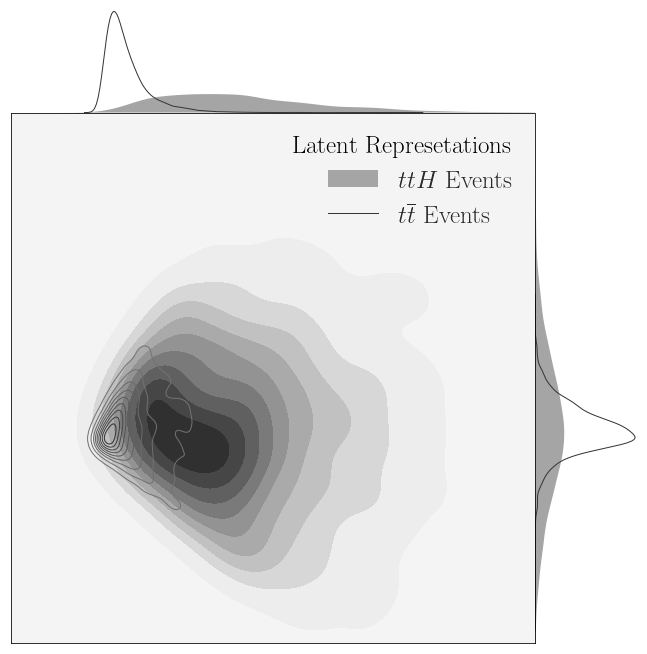

In [32]:
l2_yhat = LatentGetter(latent2.layers[0:3], condensed=True).predict(X_test_latent.numpy()[cut])
no_tsne= gen_tsne(l2_yhat, y_test_latent.numpy()[cut], text=r'Latent Represetations',
                  cmap=sns.cubehelix_palette(start=14/10, light=.97, as_cmap=True, hue=0), col_aux='#737373',
                  EMD=False,
         rotated=True, log=False, bnds=True, standardized=False)
no_tsne.savefig('figures/l2_notsne.pdf')

[ 5.21064673e-16 -1.39740071e-16] [7.28857224 3.09615173]
0.9897723523589574
earth_movers_distance 1.5903433542880685


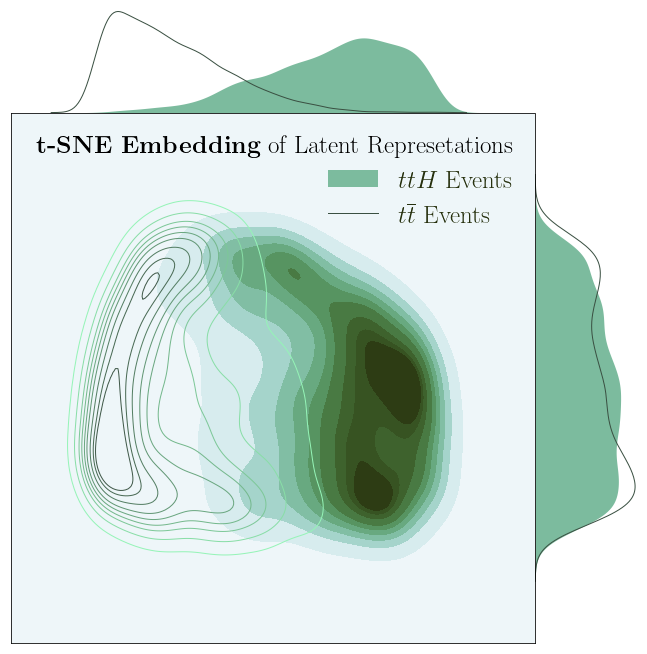

In [33]:
ax = gen_tsne(latent2_embedded, latent_label_28, text=r'\textbf{t-SNE Embedding} of Latent Represetations',
             cmap=sns.cubehelix_palette(start=14/10, light=.97, as_cmap=True), col_aux='#95f4b7',
              EMD=False)
ax.savefig('figures/l2_tsne_waxis.pdf')

In [ ]:
l64_yhat = LatentGetter(latent64.layers[0:3], condensed=True).predict(X_test.numpy()[cut])
print(emd(l64_yhat, y_test.numpy()[cut]))

In [ ]:
l8_yhat = LatentGetter(latent8.layers[0:3], condensed=True).predict(X_test_latent.numpy()[cut])
print(emd(l8_yhat, y_test_latent.numpy()[cut]))

In [ ]:
l2_yhat = LatentGetter(latent2.layers[0:3], condensed=True).predict(X_test_latent.numpy()[cut])
print(emd(l2_yhat, y_test_latent.numpy()[cut]))

In [ ]:
print(emd(np.array(X_test_ATLAS), y_test_ATLAS))

In [ ]:
TEMP_gen_tsne(latent64_embedded, latent_label, text=r'{Pairwise Architecture with} \boldmath$\mathbf{\ell=2^6}$ ',)

In [ ]:
TEMP_gen_tsne(latent8_embedded, latent_label, text=r'{Pairwise Architecture with} \boldmath$\mathbf{\ell=2^6}$ ',)

In [ ]:
TEMP_gen_tsne(latent2_embedded, latent_label, text=r'{Pairwise Architecture with} \boldmath$\mathbf{\ell=2^6}$ ',)

In [ ]:
TEMP_gen_tsne(ATLAS_embedded, latent_label, text=r'{Pairwise Architecture with} \boldmath$\mathbf{\ell=2^6}$ ',)